In [0]:
# # to install pytorch uncomment these line 
# !pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
# !pip3 install torchvision


In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim 
import glob 
import random 
import os 
from PIL import Image 
import torch.utils.data as data
import os.path
from torch.utils.data import Dataset
from torchvision import datasets,transforms
import torch.nn.functional as F 
import cv2
import matplotlib.pyplot as plt 
%matplotlib inline
IMG_EXTENSIONS = ['.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm']

In [2]:
torch.cuda.is_available()

True

In [0]:
# # To download dataset uncomment following
# %%bash
# FILE="horse2zebra"

# if [[ $FILE != "ae_photos" && $FILE != "apple2orange" && $FILE != "summer2winter_yosemite" &&  $FILE != "horse2zebra" && $FILE != "monet2photo" && $FILE != "cezanne2photo" && $FILE != "ukiyoe2photo" && $FILE != "vangogh2photo" && $FILE != "maps" && $FILE != "cityscapes" && $FILE != "facades" && $FILE != "iphone2dslr_flower" && $FILE != "ae_photos" ]]; then
#     echo "Available datasets are: apple2orange, summer2winter_yosemite, horse2zebra, monet2photo, cezanne2photo, ukiyoe2photo, vangogh2photo, maps, cityscapes, facades, iphone2dslr_flower, ae_photos"
#     exit 1
# fi

# URL=https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/$FILE.zip
# ZIP_FILE=./$FILE.zip
# TARGET_DIR=./$FILE/
# wget -N $URL -O $ZIP_FILE
# mkdir $TARGET_DIR
# unzip $ZIP_FILE -d ./
# rm $ZIP_FILE

In [0]:
batch_size = 4
nc_mnist = 1
nc_svhn = 3
nf = 64
lr = 0.0003
iters = 10000
log_interval = 5
use_cuda= torch.cuda.is_available()



In [0]:
# train_folder_a = 'iphone2dslr_flower/trainA/'
# test_folder_a = 'iphone2dslr_flower/testA/'
# train_folder_b = 'iphone2dslr_flower/trainB/'
# test_folder_b = 'iphone2dslr_flower/testB/'
train_folder_a = 'horse2zebra/trainA/'
test_folder_a = 'horse2zebra/testA/'
train_folder_b = 'horse2zebra/trainB/'
test_folder_b = 'horse2zebra/testB/'

In [0]:
train_A_imglist = os.listdir(train_folder_a)
train_B_imglist = os.listdir(train_folder_b)

In [7]:
print(len(train_A_imglist), len(train_B_imglist))

1067 1334


In [0]:
def plot_raw_imgs(imglist, dirname, idx=0):
    test_img = cv2.imread(os.path.join(dirname, imglist[idx]))
    plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

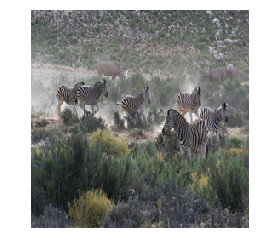

In [9]:
plot_raw_imgs(train_B_imglist, train_folder_b, 120)

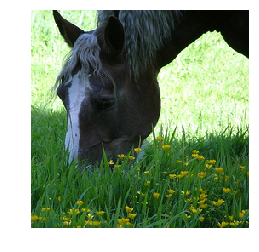

In [10]:
plot_raw_imgs(train_A_imglist, train_folder_a, 120)

In [0]:


def is_image_file(filename):
    """Checks if a file is an image.

    Args:
        filename (string): path to a file

    Returns:
        bool: True if the filename ends with a known image extension
    """
    filename_lower = filename.lower()
    return any(filename_lower.endswith(ext) for ext in IMG_EXTENSIONS)



def cv_loader(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return Image.fromarray(img)

def make_dataset(dir):
    images = []
    dir = os.path.expanduser(dir)
    for target in sorted(os.listdir(dir)):
        d = os.path.join(dir, target)
#         if not os.path.isdir(d):
#             continue

        if is_image_file(d):
#             path = os.path.join(dir, d)
#             item = path#(path, class_to_idx[target])
            images.append(d)

    return images          

class ImageFolder(data.Dataset):
    """A generic data loader where the images are arranged in this way: ::

        root/dog/xxx.png
        root/dog/xxy.png
        root/dog/xxz.png

        root/cat/123.png
        root/cat/nsdf3.png
        root/cat/asd932_.png

    Args:
        root (string): Root directory path.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        loader (callable, optional): A function to load an image given its path.

     Attributes:
        classes (list): List of the class names.
        class_to_idx (dict): Dict with items (class_name, class_index).
        imgs (list): List of (image path, class_index) tuples
    """

    def __init__(self, root, transform=None, target_transform=None,
                 loader=cv_loader):
#         classes, class_to_idx = find_classes(root)
        imgs = make_dataset(root)
        if len(imgs) == 0:
            raise(RuntimeError("Found 0 images in subfolders of: " + root + "\n"
                               "Supported image extensions are: " + ",".join(IMG_EXTENSIONS)))

        self.root = root
        self.imgs = imgs
       
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is class_index of the target class.
        """
        path = self.imgs[index]
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
#         if self.target_transform is not None:
#             target = self.target_transform(target)

        return img


    def __len__(self):
        return len(self.imgs)

In [0]:
def get_iphone_dataset(batch_size, im_size=300, random_crop_size=256):
    random_crop_size = 256 
    transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.Resize(im_size),
         transforms.RandomCrop(random_crop_size),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)])

    train_a_ = ImageFolder(root='horse2zebra/trainA/', transform=transform)
    train_b_ = ImageFolder(train_folder_b, transform=transform)
    test_a_ = ImageFolder(test_folder_a, transform=transform)
    test_b_ = ImageFolder(test_folder_b, transform=transform)

    train_a_loader=torch.utils.data.DataLoader(train_a_, batch_size=batch_size,
                                           shuffle=True, num_workers=1)
    train_b_loader=torch.utils.data.DataLoader(train_b_, batch_size=batch_size,
                                           shuffle=True, num_workers=1)
    
    return train_a_loader, train_b_loader
    




In [0]:
a_loader,b_loader = get_iphone_dataset(batch_size=32)

In [0]:
def get_mnist_svhn_loader(batch_size, im_size=32):
    use_cuda = torch.cuda.is_available()
    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

    svhn = datasets.SVHN(root='./data', download=True, 
        transform=transforms.Compose([
            transforms.Scale(im_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5,0.5,0.5), (0.5, 0.5, 0.5))
        ]))
    
    mnist = datasets.MNIST(root='./data',train=True,download=True,
        transform=transforms.Compose([
                    transforms.Scale(im_size),
                    transforms.ToTensor(),
                    transforms.Normalize((0.1307,), (0.3081,))]
        ))

    svhn_loader = torch.utils.data.DataLoader(dataset=svhn,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        **kwargs)

    mnist_loader = torch.utils.data.DataLoader(dataset=mnist,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        **kwargs)
    return svhn_loader, mnist_loader 

In [0]:
# load datasets
# svhn_loader, mnist_loader = get_mnist_svhn_loader(batch_size)

## Networks

In [0]:
def conv3x3(in_planes, out_planes, stride=1):

    return nn.Conv2d(in_planes, out_planes, kernel_size=3,
            stride=stride, padding=1, bias=False)



class ResidualBlock(nn.Module):
    def __init__(self, in_planes):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = conv3x3(in_planes,in_planes)
        self.norm1 = nn.InstanceNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = conv3x3(in_planes,in_planes)
        self.norm2 = nn.InstanceNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)

    def forward(self,x):
        residual = x 
        x = self.conv1(x)
        x = self.relu(self.norm1(x))

        x = self.conv2(x)
        x = self.norm2(x)

        return self.relu(residual + x) 

      
class GenM2S(nn.Module):
    def __init__(self, nc=1, nf=64, nout=3):
        super(GenM2S, self).__init__()
        
        self.first_block = nn.Sequential(
            nn.Conv2d(nc, nf, 3,stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(nf),
            nn.ReLU(inplace=True)
        )

        # downsample
        self.downsample = nn.Sequential(
            nn.Conv2d(nf, nf*2, 3, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(nf*2),
            nn.ReLU(inplace=True),
            nn.Conv2d(nf*2, nf*4, 3, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(nf*4),
            nn.ReLU(inplace=True)
        )

        # residual blocks 
        
        self.res_blocks = nn.Sequential(
            ResidualBlock(nf*4),
            ResidualBlock(nf*4)
        )


        # upsample 
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(nf*4, nf*2, 4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(nf*2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(nf*2, nout, 3, stride=2, padding=1, output_padding=1, bias=False),
            nn.Tanh()
        )

        


    def forward(self, x):
        x = self.first_block(x)
        x = self.downsample(x)
        x = self.res_blocks(x)
        x = self.upsample(x)
        return x

class GenS2M(nn.Module):
    def __init__(self, nc=3, nf=64, nout=1):
        super(GenS2M, self).__init__()
        self.first_block = nn.Sequential(
            nn.Conv2d(nc, nf, 3,stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(nf),
            nn.ReLU(inplace=True)
        )

        # downsample
        self.downsample = nn.Sequential(
            nn.Conv2d(nf, nf*2, 3, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(nf*2),
            nn.ReLU(inplace=True),
            nn.Conv2d(nf*2, nf*4, 3, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(nf*4),
            nn.ReLU(inplace=True)
        )

        # residual blocks 
        
        self.res_blocks = nn.Sequential(
            ResidualBlock(nf*4),
            ResidualBlock(nf*4)
        )


        # upsample 
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(nf*4, nf*2, 3, stride=2, bias=False),
            nn.InstanceNorm2d(nf*2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(nf*2, nout, 3, stride=2,padding=2,output_padding=1, bias=False),
            nn.Tanh()
        )

        

    def forward(self, x):
        x = self.first_block(x)
        x = self.downsample(x)
        x = self.res_blocks(x)
        x = self.upsample(x)
        return x


class Discriminator(nn.Module):
    def __init__(self, nc, nf=64):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(nc, nf, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(nf, nf*2, 4, stride=2, padding=1),
            nn.InstanceNorm2d(nf*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(nf*2, nf*4, 4, stride=2, padding=1),
            nn.InstanceNorm2d(nf*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(nf*4, nf*8, 4, padding=1),
            nn.InstanceNorm2d(nf*8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(nf*8, 1, 4, padding=1)
        )
        
    def forward(self, x):
        x = self.model(x)
        return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)


In [0]:
# custom weights initialization called on G and D
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [18]:
#@title
# mnist to svhn 
G12 = GenM2S(3, 64, 3)
G12.apply(weights_init)
# print(G12)

# svhn to mnist 
G21 = GenS2M(3, 64, 3)
G21.apply(weights_init)
# print(G21)

# D1 (MNIST)
D1 = Discriminator(1)
D1.apply(weights_init)
# print(D1)

# D2 (SVHN)
D2 = Discriminator(3)
D2.apply(weights_init)
# print(D2)



Discriminator(
  (model): Sequential(
    (0): Conv2d (3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(0.2, inplace)
    (2): Conv2d (64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False)
    (4): LeakyReLU(0.2, inplace)
    (5): Conv2d (128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False)
    (7): LeakyReLU(0.2, inplace)
    (8): Conv2d (256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False)
    (10): LeakyReLU(0.2, inplace)
    (11): Conv2d (512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [0]:

# loss and optimizers
criterion = nn.CrossEntropyLoss()

optim_g = optim.Adam(list(G12.parameters()) + list(G21.parameters()), 
                    lr, [0.5, 0.999])

optim_d = optim.Adam(list(D1.parameters()) + list(D2.parameters()),
                     lr=lr)

In [0]:
if use_cuda:
    G12.cuda()
    G21.cuda()
    D1.cuda()
    D2.cuda()
    criterion.cuda()
    

In [0]:
def to_var(x):
    if use_cuda:
        x = x.cuda()
    return Variable(x)

def to_data(x):
    if use_cuda:
        x = x.cpu()
    return x.data.numpy()

def reset_grad():
    optim_g.zero_grad()
    optim_d.zero_grad()

In [0]:
def train_d(s_var, m_var, is_real=True):
    # train D
    # train with real image
    reset_grad()

    #forward mnist
    m_out = D1(m_var)

    # discriminator loss  mnist
    if is_real:
        m_d_loss = torch.mean((m_out-1)**2)
    else:
        m_d_loss = torch.mean(m_out**2)

    # forward svhn
    s_out = D2(s_var)

    # D_loss svhn
    if is_real:
        s_d_loss = torch.mean((s_out-1)**2)
    else:
        s_d_loss = torch.mean((s_out)**2)
    
    # total d ral image loss
    d_real_loss = m_d_loss + s_d_loss

    # compute backward pass
    d_real_loss.backward()

    # update weights
    optim_d.step()

    return m_d_loss, s_d_loss

In [0]:
def train():
    svhn_iter = iter(a_loader)
    mnist_iter = iter(b_loader)
    iter_per_epoch = min(len(svhn_iter), len(mnist_iter))

    fixed_svhn_var = to_var(svhn_iter.next()[0])
    fixed_mnist_var = to_var(mnist_iter.next()[0])
    count = 0
    for step in range(iters):
        if (step+1) % iter_per_epoch == 0:
            print("New epoch starts")
            svhn_iter = iter(svhn_loader)
            mnist_iter = iter(mnist_loader)

        s_data, s_labels = svhn_iter.next()
        s_data, s_labels = to_var(s_data), to_var(s_labels)
        m_data, m_labels = mnist_iter.next()
        m_data, m_labels = to_var(m_data), to_var(m_labels)

        # train D with real 
        s_real_loss, m_real_loss = train_d(s_data, m_data)

        # train D with fake
        # get fake svhn 
        s_fake = G12(m_data)
        
        # get fake mnist
        m_fake = G21(s_data)
        
        s_fake_loss, m_fake_loss = train_d(s_fake, m_fake, is_real=False)


        # train G 
        # mnist--> svhn--> mnist
        reset_grad()
        s_fake = G12(m_data)
        m_fake = G21(s_fake)
        s_out = D2(s_fake)
        
        # print(m_fake, m_data)
        msm_recons_loss = torch.mean((m_data-m_fake)**2)
        msm_d_loss = torch.mean((s_out-1)**2)

        # total loss and update
        msm_g_loss = msm_recons_loss + msm_d_loss
        msm_g_loss.backward()
        optim_g.step()


        # svhn --> mnist-->svhn
        reset_grad()
        m_fake = G21(s_data)
        s_fake = G12(m_fake)
        m_out = D1(m_fake)
        sms_recons_loss = torch.mean((s_data-s_fake)**2)
        sms_d_loss = torch.mean((m_out-1)**2)

        # total loss and update
        sms_g_loss = sms_recons_loss + sms_d_loss
        sms_g_loss.backward()
        optim_g.step()


        #if(step+1) % log_interval == 0:
        print('Step [%d], d_loss: %.4f, d_fake_loss: %.4f, g_loss: %.4f'
              %(step+1, (s_real_loss+m_real_loss).data[0],(s_fake_loss+m_fake_loss).data[0],(msm_g_loss + sms_g_loss).data[0]))
#         vis.line(
#             X=torch.ones((1, 2)).cpu()*count,
#             Y=torch.Tensor(
#                 [(msm_g_loss + sms_g_loss).data[0], (s_real_loss+m_real_loss).data[0]]).unsqueeze(0).cpu(),
#             win=lot,
#             update='append'
#         )
        count+=1

#         if step % 100 == 0:
#             m1_fake_fixed=G21(fixed_svhn_var)
#             s1_fake_fixed=G12(m1_fake_fixed)

            
#             s2_fake_fixed=G12(fixed_mnist_var)
#             m2_fake_fixed=G21(s2_fake_fixed)

#             concat_t=torch.cat(
#                 [fixed_svhn_var.cpu(), s1_fake_fixed.cpu().data, fixed_mnist_var.cpu().data, m2_fake_fixed.cpu().data], dim=2)

#             grid=vutils.make_grid(concat_t)
#             ndarr=grid.mul(255).clamp(0, 255).byte().numpy()

#             vis.image(ndarr, opts=dict(title='Recons',
#                                         caption='Epoch {} iter {}'.format(count, i)))



In [24]:
train()

Process Process-2:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


KeyboardInterrupt: ignored